In [2]:
import dagshub
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/AJINKYA-TEMGIRE/Influencers-Comment-Analysis.mlflow")
dagshub.init(repo_owner='AJINKYA-TEMGIRE', repo_name='Emotion_Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=81fbf106-5dac-497e-be72-61468af55939&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=017f76cff8f1ce07e22884e2e5b60bd0149ec8969211ef37d24137f97ed14554




Accessing as AJINKYA-TEMGIRE

Initialized MLflow to track repo "AJINKYA-TEMGIRE/Emotion_Detection"

Repository AJINKYA-TEMGIRE/Emotion_Detection initialized!

In [3]:
import pandas as pd
import numpy as np


df =  pd.read_csv(r"../data/raw/Reddit-Data.csv")

df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df.dropna(inplace = True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [10]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [11]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [12]:
df.to_csv(r"../data/interim/cleaned_data.csv" , index = False)

In [13]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=1000)  # Bag of Words model with a limit of 1000 features

In [15]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [16]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

2025/02/02 12:36:26 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/d970cfa505394d5faa9c53d9a215f22d', creation_time=1738479986799, experiment_id='0', last_update_time=1738479986799, lifecycle_stage='active', name='RF Baseline', tags={}>

c:\Python 310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
c:\Python 310\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Accuracy: 0.6615029215926077


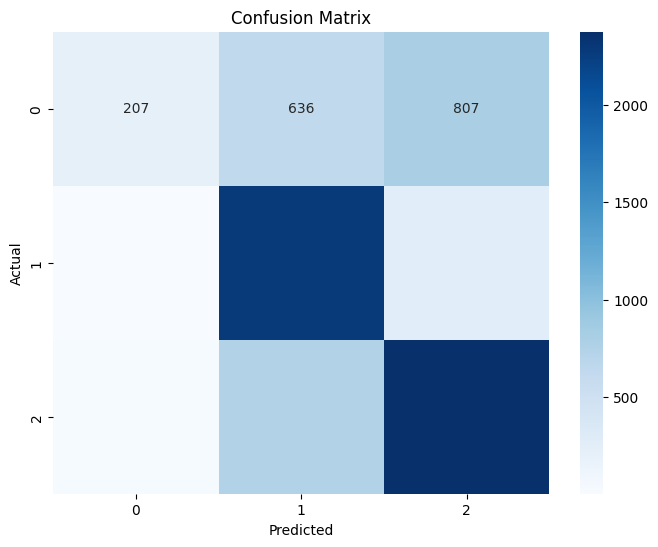

In [17]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig(r"../reports/figures/baseline-confusion_matrix.png")
    mlflow.log_artifact(r"../reports/figures/baseline-confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    dataset = mlflow.data.from_pandas(df)
    mlflow.log_input(dataset , "data")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [20]:
'''
Baseline model observations:
    -1 class has high precision and low recall (class imbalance)
    Focusing on accuracy and recall

'''

print(classification_rep)

{'-1': {'precision': 0.8661087866108786, 'recall': 0.12545454545454546, 'f1-score': 0.21916357861302277, 'support': 1650.0}, '0': {'precision': 0.6225490196078431, 'recall': 0.8947162426614481, 'f1-score': 0.734221936727156, 'support': 2555.0}, '1': {'precision': 0.6888051044083526, 'recall': 0.7530120481927711, 'f1-score': 0.7194789457740078, 'support': 3154.0}, 'accuracy': 0.6615029215926077, 'macro avg': {'precision': 0.7258209702090248, 'recall': 0.5910609454362549, 'f1-score': 0.5576214870380621, 'support': 7359.0}, 'weighted avg': {'precision': 0.7055555839529737, 'recall': 0.6615029215926077, 'f1-score': 0.6124192890366342, 'support': 7359.0}}
